In [ ]:
!pip3 install flair

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import torch
torch.cuda.is_available()

True

> ## Create a Corpus

### 1) Load from simple CSV file

In [2]:
from flair.datasets import CSVClassificationCorpus

ImportError: cannot import name 'CSVClassificationCorpus'

Great development..

### 2) FastText Format

In [3]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [4]:
FILE_PATH = "data/bbc-text.csv"
DATASET_FOLDER_PATH = os.path.join("splitted_data", FILE_PATH.split(".")[0].split("/")[1])

column_name = {
    "text": "text",
    "label": "category"
}

# file format
__label__<label_1> <text>
__label__<label_1> __label__<label_2> <text>

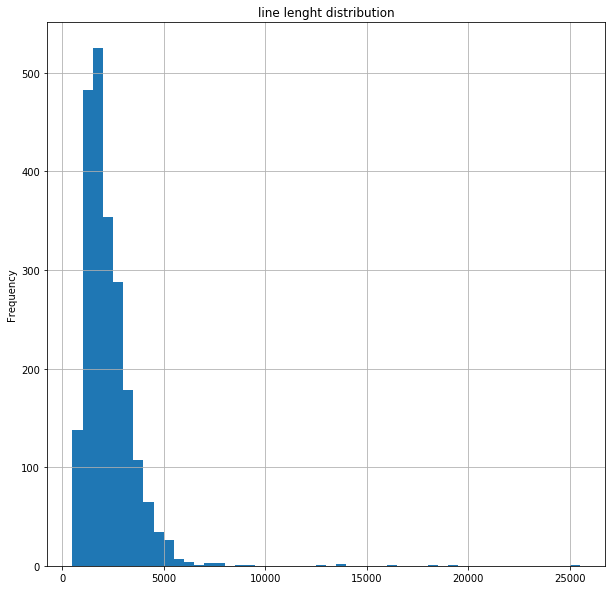

In [6]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df[column_name["label"]] = '__label__' + data_df[column_name["label"]].astype(str)

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

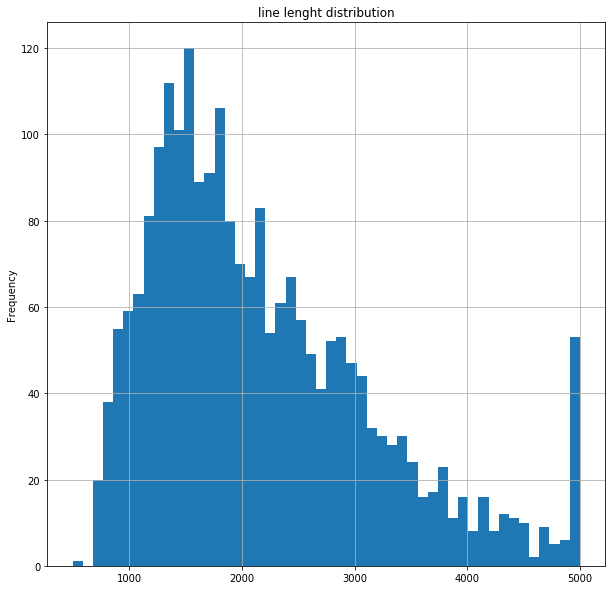

In [7]:
import re
from string import digits, punctuation

def clear_text(text, is_all_lower=True):
    punct = re.sub(r'[\.,!?&\-]', '', punctuation)
    punctuation_table = str.maketrans({key: "#" for key in punct})
    for char in ["\"", "\'"]:
        del punctuation_table[ord(char)]
    
    review_cleaned = text.apply(lambda x: re.sub(r'[^\x00-\x7F]', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r'[0-9]', '9', x))
    review_cleaned = review_cleaned.apply(lambda x: x.translate(punctuation_table))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' +', ' ', x))
    review_cleaned = review_cleaned.apply(lambda x: re.sub(r' (?=[\.,!?&\-])','', x))
    
    if is_all_lower:
        review_cleaned = review_cleaned.str.lower()
        
    return review_cleaned

data_df[column_name["text"]] = clear_text(data_df["text"])
data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="line lenght distribution", grid=True, figsize=(10,10), bins=50);

In [8]:
if not os.path.exists(DATASET_FOLDER_PATH):
    os.makedirs(DATASET_FOLDER_PATH)
data_df.iloc[0: int(len(data_df)*0.8)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'train.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.8): int(len(data_df)*0.9)].to_csv(os.path.join(DATASET_FOLDER_PATH, 'dev.csv'), sep='\t', index = False, header = False)
data_df.iloc[int(len(data_df)*0.9): ].to_csv(os.path.join(DATASET_FOLDER_PATH, 'test.csv'), sep='\t', index = False, header = False);

In [9]:
corpus = ClassificationCorpus(DATASET_FOLDER_PATH)

2019-08-10 20:32:41,179 Reading data from splitted_data/bbc-text
2019-08-10 20:32:41,181 Train: splitted_data/bbc-text/train.csv
2019-08-10 20:32:41,182 Dev: splitted_data/bbc-text/dev.csv
2019-08-10 20:32:41,183 Test: splitted_data/bbc-text/test.csv


Each line in a corpus is converted to a Sentence object annotated with the labels.

## Check distribution

In [10]:
train_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "train.csv"), names=["label", "text"], delimiter="\t")
train_df.label.value_counts()

__label__business         412
__label__sport            405
__label__politics         336
__label__entertainment    316
__label__tech             311
Name: label, dtype: int64

In [11]:
val_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "dev.csv"), names=["label", "text"], delimiter="\t")
val_df.label.value_counts()

__label__tech             55
__label__sport            48
__label__business         47
__label__politics         39
__label__entertainment    33
Name: label, dtype: int64

In [12]:
test_df = pd.read_csv(os.path.join(DATASET_FOLDER_PATH, "test.csv"), names=["label", "text"], delimiter="\t")
test_df.label.value_counts()

__label__sport            58
__label__business         51
__label__politics         42
__label__entertainment    37
__label__tech             35
Name: label, dtype: int64

## Training a Model

## XLNet

In [3]:
from flair.embeddings import XLNetEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric
# from flair.visual.training_curves import Plotter

ImportError: cannot import name 'XLNetEmbeddings'

In [16]:
MODEL_FOLDER_PATH = "model/XLNet"
if not os.path.exists(MODEL_FOLDER_PATH):
    os.makedirs(MODEL_FOLDER_PATH)

In [ ]:
params_train = {
    "flair_emb_forward": 'news-forward-fast',
    "flair_emb_backward": 'news-backward-fast',
    "hidden_size": 256,
    "reproject_words_dimension": 128,
    "max_epoch": 20,
    "evaluation_metric": EvaluationMetric.MICRO_ACCURACY
}

word_embeddings = [XLNetEmbeddings(), FlairEmbeddings(params_train["flair_emb_forward"]),
                   FlairEmbeddings(params_train["flair_emb_backward"])]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=params_train["hidden_size"],
                                            reproject_words=True, reproject_words_dimension=params_train["reproject_words_dimension"])

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

trainer = ModelTrainer(classifier, corpus)

In [ ]:
learning_rate_tsv = trainer.find_learning_rate(MODEL_FOLDER_PATH, 'learning_rate.tsv')

plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

In [ ]:
trainer.train(MODEL_FOLDER_PATH, max_epochs=params_train["max_epoch"], evaluation_metric=params_train["evaluation_metric"])

## Plot training curves

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(MODEL_FOLDER_PATH, 'loss.tsv'))
plotter.plot_weights(os.path.join(MODEL_FOLDER_PATH, 'weights.txt'))